In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


In [119]:
df = pd.read_csv('churn_data.csv')

In [120]:
df

,number,system_id,grade_sect_cd,mbr_sex_cd,tmon_pchrg_lrn_dcnt,acmlt_pchrg_lrn_dcnt,acmlt_bilclct_amt,correct_rate_avg,learning_time_avg,media_action_cnt_sum,non_video_viewed_cnt_sum,get_mm_point_sum,label,re_purch
0,3,87ee0282-ece5-4491-bb07-be93854750ac,G011,M,31.0,247.0,952000.0,0.59,670.48,673.0,306.0,1377.0,0,False
1,7,8817ada1-b7ad-4713-b041-ee180540cb87,G011,M,31.0,238.0,1071000.0,0.00,0.00,0.0,0.0,0.0,0,False
2,8,884cddf4-bda5-4d81-960c-b9a4892645f0,G011,F,31.0,92.0,436000.0,0.70,400.44,1067.0,468.0,6289.0,0,False
3,21,8a58832b-592b-4b33-b05e-0e11422d73d5,G011,M,31.0,370.0,1417000.0,0.81,914.47,840.0,212.0,1714.0,0,False
4,25,8af8f516-a9f0-4b6a-a27f-fc77ba51f708,G011,M,1.0,1.0,109000.0,0.00,0.00,0.0,0.0,0.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,66969,3d97d2c6-50dd-4c12-9fee-01578d691b0d,G016,F,31.0,613.0,1180000.0,0.69,262.33,41.0,26.0,590.0,0,True
59996,66986,41258431-f36d-46e7-a0d4-43f98edafd21,G016,M,31.0,62.0,178000.0,0.69,164.69,429.0,187.0,812.0,0,True
59997,66987,4157bf9d-92ea-4656-a2f6-9ac53ced8328,G016,F,31.0,217.0,872000.0,0.43,353.55,853.0,417.0,3064.0,0,False
59998,66988,416c8ba3-330b-45fc-aae8-91b548c28b3d,G016,M,31.0,312.0,869000.0,0.68,172.41,930.0,234.0,1092.0,0,True


In [121]:
del df['number']

In [122]:
#결측치 없음
df.isna().sum()

system_id                   0
grade_sect_cd               0
mbr_sex_cd                  0
tmon_pchrg_lrn_dcnt         0
acmlt_pchrg_lrn_dcnt        0
acmlt_bilclct_amt           0
correct_rate_avg            0
learning_time_avg           0
media_action_cnt_sum        0
non_video_viewed_cnt_sum    0
get_mm_point_sum            0
label                       0
re_purch                    0
dtype: int64

In [123]:
def change_value(values):
    if values == 'G011':
        return 1
    elif values == 'G012':
        return 2
    elif values == 'G013':
        return 3
    elif values == 'G014':
        return 4
    elif values == 'G015':
        return 5
    elif values == 'G016':
        return 6
    
df['grade'] = df['grade_sect_cd'].apply(change_value)
df[['grade']]
    


,grade
0,1
1,1
2,1
3,1
4,1
...,...
59995,6
59996,6
59997,6
59998,6


In [125]:
df.groupby('mbr_sex_cd')['label'].value_counts()
#남녀+X로 라벨 나누기

mbr_sex_cd  label
F           0        25064
            1          377
M           0        32310
            1          533
X           0         1694
            1           22
Name: count, dtype: int64

In [127]:
# X --> M(최빈값)
df['mbr_sex_cd'].replace({'X' : "M"}, inplace=True)

In [128]:
df['mbr_sex_cd'].value_counts()

mbr_sex_cd
M    34559
F    25441
Name: count, dtype: int64

In [129]:
df_M = df.query('mbr_sex_cd == "M"').reset_index()
df_F = df.query('mbr_sex_cd == "F"').reset_index()

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   system_id                 60000 non-null  object 
 1   grade_sect_cd             60000 non-null  object 
 2   mbr_sex_cd                60000 non-null  object 
 3   tmon_pchrg_lrn_dcnt       60000 non-null  float64
 4   acmlt_pchrg_lrn_dcnt      60000 non-null  float64
 5   acmlt_bilclct_amt         60000 non-null  float64
 6   correct_rate_avg          60000 non-null  float64
 7   learning_time_avg         60000 non-null  float64
 8   media_action_cnt_sum      60000 non-null  float64
 9   non_video_viewed_cnt_sum  60000 non-null  float64
 10  get_mm_point_sum          60000 non-null  float64
 11  label                     60000 non-null  int64  
 12  re_purch                  60000 non-null  bool   
 13  grade                     60000 non-null  int64  
dtypes: boo

In [131]:
x1 = df_M[['grade',
    'tmon_pchrg_lrn_dcnt',
       'acmlt_pchrg_lrn_dcnt',
       'acmlt_bilclct_amt',
       'correct_rate_avg', 
        'learning_time_avg',
        'media_action_cnt_sum',
        'non_video_viewed_cnt_sum']]
y1 = df_M['label']

In [132]:
x2 = df_F[['grade',
    'tmon_pchrg_lrn_dcnt',
       'acmlt_pchrg_lrn_dcnt',
       'acmlt_bilclct_amt',
       'correct_rate_avg', 
        'learning_time_avg',
        'media_action_cnt_sum',
        'non_video_viewed_cnt_sum']]
y2 = df_F['label']

In [133]:
X1_train, X1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, random_state=42)

In [134]:
    print(f"남자, train 전체: {len(X1_train)}, 이탈 : {y1_train[y1_train==1].shape[0]}, 미이탈: {y1_train[y1_train==0].shape[0]} ")
    print(f"남자, test 전체: {len(X1_test)}, 이탈 : {y1_test[y1_test==1].shape[0]}, 미이탈: {y1_test[y1_test==0].shape[0]} ")
    print(f"여자, train 전체: {len(X2_train)}, 이탈 : {y2_train[y2_train==1].shape[0]}, 미이탈: {y2_train[y2_train==0].shape[0]} ")
    print(f"여자, test 전체: {len(X2_test)}, 이탈 : {y2_test[y2_test==1].shape[0]}, 미이탈: {y2_test[y2_test==0].shape[0]} ")
    

남자, train 전체: 27647, 이탈 : 461, 미이탈: 27186 
남자, test 전체: 6912, 이탈 : 94, 미이탈: 6818 
여자, train 전체: 20352, 이탈 : 299, 미이탈: 20053 
여자, test 전체: 5089, 이탈 : 78, 미이탈: 5011 


In [135]:
#로지스틱 회귀 
log_model_M = LogisticRegression(random_state=0)
log_model_M.fit(X=X1_train, y=y1_train)

log_model_F = LogisticRegression(random_state=0)
log_model_F.fit(X=X2_train, y=y2_train)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [136]:
#남자 예측
y1_pred = log_model_M.predict(X1_test)
y1_pred = list(y1_pred)
print(f"[predict] 이탈: {y1_pred.count(1)}, 미이탈 : {y1_pred.count(0)}")

[predict] 이탈: 26, 미이탈 : 6886


In [137]:
#여자 예측
y2_pred = log_model_F.predict(X2_test)
y2_pred = list(y2_pred)
print(f"[predict] 이탈: {y2_pred.count(1)}, 미이탈 : {y2_pred.count(0)}")

[predict] 이탈: 0, 미이탈 : 5089


In [144]:
accuracy_score(y1_test, y1_pred)


0.9835069444444444

In [145]:
accuracy_score(y2_test, y2_pred)

0.984672823737473

In [146]:
precision_recall_fscore_support(y1_test, y1_pred, average='binary')

(0.11538461538461539, 0.031914893617021274, 0.05, None)

In [147]:
precision_recall_fscore_support(y2_test, y2_pred, average='binary')

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0, 0.0, 0.0, None)

In [150]:
from sklearn.metrics import confusion_matrix

log_cm_M = confusion_matrix(y1_test, y1_pred) 

print(log_cm_M)

[[6795   23]
 [  91    3]]


In [151]:
log_cmtx_M = pd.DataFrame(
    confusion_matrix(y1_test, y1_pred, labels= [1, 0]),
    index = ['실제 : 이탈 1', '실제 : 미이탈 0'],
    columns = ['예측 : 이탈 1', '예측 : 미이탈 0']
)

print(log_cmtx_M)

            예측 : 이탈 1  예측 : 미이탈 0
실제 : 이탈 1           3          91
실제 : 미이탈 0         23        6795


In [148]:
from sklearn.metrics import confusion_matrix

log_cm_F = confusion_matrix(y2_test, y2_pred) 

print(log_cm_F)

[[5011    0]
 [  78    0]]


In [149]:
log_cmtx_F = pd.DataFrame(
    confusion_matrix(y2_test, y2_pred, labels= [1, 0]),
    index = ['실제 : 이탈 1', '실제 : 미이탈 0'],
    columns = ['예측 : 이탈 1', '예측 : 미이탈 0']
)

print(log_cmtx_F)

            예측 : 이탈 1  예측 : 미이탈 0
실제 : 이탈 1           0          78
실제 : 미이탈 0          0        5011


# light gbm

In [91]:
lgbm_model_M = LGBMClassifier(random_state = 0, verbose = 0)
lgbm_model_M.fit(X1_train, y1_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


LGBMClassifier(random_state=0, verbose=0)

In [92]:
lgbm_model_F = LGBMClassifier(random_state = 0, verbose = 0)
lgbm_model_F.fit(X2_train, y2_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


LGBMClassifier(random_state=0, verbose=0)

In [93]:
y1_pred = lgbm_model_M.predict(X1_test)
y1_pred = list(y1_pred)
print(f"예측 이탈 : {y1_pred.count(1)}, 미이탈 :{y1_pred.count(0)}")

예측 이탈 : 81, 미이탈 :6831


In [94]:
y2_pred = lgbm_model_F.predict(X2_test)
y2_pred = list(y2_pred)
print(f"예측 이탈 : {y2_pred.count(1)}, 미이탈 :{y2_pred.count(0)}")

예측 이탈 : 61, 미이탈 :5028


In [95]:
accuracy_score(y1_test, y1_pred)

0.9940682870370371

In [96]:
accuracy_score(y2_test, y2_pred)

0.9919434073491845

In [97]:
precision_recall_fscore_support(y1_test, y1_pred, average='binary')

(0.8271604938271605, 0.7127659574468085, 0.7657142857142857, None)

In [98]:
precision_recall_fscore_support(y2_test, y2_pred, average='binary')

(0.8032786885245902, 0.6282051282051282, 0.7050359712230215, None)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

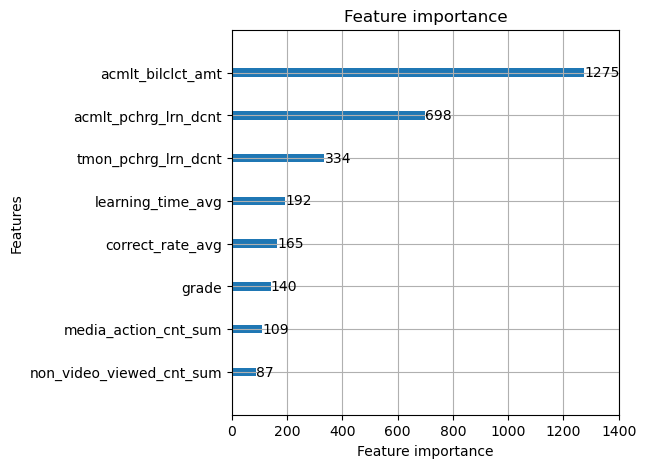

In [99]:
fig, ax = plt.subplots(figsize = (5,5))
plot_importance(lgbm_model_M, ax = ax)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

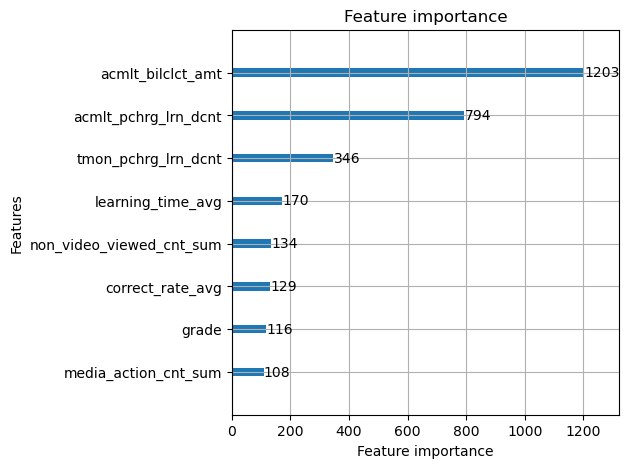

In [100]:
fig, ax = plt.subplots(figsize = (5,5))
plot_importance(lgbm_model_F, ax = ax)

In [104]:
from sklearn.metrics import confusion_matrix
cm_M = confusion_matrix(y1_test, y1_pred) 
cm_F = confusion_matrix(y2_test, y2_pred) 

print(cm_M)
print(cm_F)

[[6804   14]
 [  27   67]]
[[4999   12]
 [  29   49]]


In [113]:
cmtx_M = pd.DataFrame(
    confusion_matrix(y1_test, y1_pred, labels= [1, 0]),
    index = ['실제 : 이탈 1', '실제 : 미이탈 0'],
    columns = ['예측 : 이탈 1', '예측 : 미이탈 0']
)

cmtx_F = pd.DataFrame(
    confusion_matrix(y2_test, y2_pred, labels= [1, 0]),
    index = ['실제 : 이탈 1', '실제 : 미이탈 0'],
    columns = ['예측 : 이탈 1', '예측 : 미이탈 0']
)
print(cmtx_M)
print("#########################################")
print(cmtx_F)

            예측 : 이탈 1  예측 : 미이탈 0
실제 : 이탈 1          67          27
실제 : 미이탈 0         14        6804
#########################################
            예측 : 이탈 1  예측 : 미이탈 0
실제 : 이탈 1          49          29
실제 : 미이탈 0         12        4999


In [110]:
#precision
pre_M = cmtx_M.iloc[0, 0] / (cmtx_M.iloc[0, 0] + cmtx_M.iloc[1, 0])
pre_F = cmtx_F.iloc[0, 0] / (cmtx_F.iloc[0, 0] + cmtx_F.iloc[1, 0])

print(f"남자 precision: {pre_M}")
print(f"여자 precision: {pre_F}")
print("//////////////////////////")

#recall
re_M = cmtx_M.iloc[0, 0] / (cmtx_M.iloc[0, 0] + cmtx_M.iloc[0, 1])
re_F = cmtx_F.iloc[0, 0] / (cmtx_F.iloc[0, 0] + cmtx_F.iloc[0, 1])

print(f"남자 recall : {re_M}")
print(f"여자 recall : {re_F}")
print("//////////////////////////")

#F1_score
f1_M = (2*(pre_M*re_M)) / (pre_M+re_M)
f1_F = (2*(pre_F*re_F)) / (pre_F+re_F)

print(f"남자 f1-score : {f1_M}")
print(f"여자 f1-score : {f1_F}")


남자 precision: 0.8271604938271605
여자 precision: 0.8032786885245902
//////////////////////////
남자 recall : 0.7127659574468085
여자 recall : 0.6282051282051282
//////////////////////////
남자 f1-score : 0.7657142857142857
여자 f1-score : 0.7050359712230215


In [116]:
# LightGBM 모델 생성
model = LGBMClassifier(verbose = -1)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves' : [10, 20, 30], 
    'max_depth' : [3, 5, 7],
    'learning_rate' : [0.01, 0.05, 0.1],
    'min_child_samples' : [10, 20, 30]
}

# GridSearchCV 객체 생성

grid_search = GridSearchCV(estimator=model, param_grid=param_grid)

# 그리드 서치 수행
grid_search.fit(X1_train, y1_train)

# 최적의 하이퍼파라미터
print(grid_search.best_params_)
# 최적의 하이퍼파라미터로 학습된 모델 가져오기
best_model = grid_search.best_estimator_
y1_pred = best_model.predict(X1_test)
# 예측 수행
precision_recall_fscore_support(y1_test, y1_pred, average='binary')

{'learning_rate': 0.1, 'max_depth': 7, 'min_child_samples': 20, 'num_leaves': 20}


(0.85, 0.723404255319149, 0.7816091954022989, None)

In [117]:
# 그리드 서치 수행
grid_search.fit(X2_train, y2_train)

# 최적의 하이퍼파라미터
print(grid_search.best_params_)
# 최적의 하이퍼파라미터로 학습된 모델 가져오기
best_model = grid_search.best_estimator_
y2_pred = best_model.predict(X2_test)
# 예측 수행
precision_recall_fscore_support(y2_test, y2_pred, average='binary')

{'learning_rate': 0.1, 'max_depth': 7, 'min_child_samples': 20, 'num_leaves': 20}


(0.7894736842105263, 0.5769230769230769, 0.6666666666666666, None)